In [1]:
import numpy as np
import scipy.io.wavfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import parse_records as pr
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import scipy as sc
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

labels = mnist.test.labels[:100]

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [17]:
weights = np.load("epoch_weights.npy")
weights.shape

(7, 100, 2)

## Maintain as DF

In [26]:
import pandas as pd
df1 = pd.DataFrame(weights[0])
df1['labels'] = labels

df2 = pd.DataFrame(weights[1])
df2['labels'] = labels

In [36]:
df1.iloc[:5, :2]

,0,1
0,-0.726482,9.907635
1,-3.512014,7.062853
2,-1.657359,3.944501
3,9.111806,1.961343
4,5.801595,7.121058


# Try to align first two epochs

In [52]:
#Target matrix = what you're trying to match
#Source matrix = original matrix you're trying to rotate
source_matrix = (df2.iloc[:, :2]).values
target_matrix = (df1.iloc[:, :2]).values

In [53]:
print(source_matrix.shape, target_matrix.shape)

(100, 2) (100, 2)


In [54]:
def make_transform(source_matrix, target_matrix):
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)
    trans = np.matmul(U, V)
    return trans

In [55]:
def make_apply_transform(source_matrix, target_matrix):
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)
    trans = np.matmul(U, V)
    #target_matrix_new = np.matmul(target_matrix, trans)
    source_new = np.matmul(source_matrix, trans)
    return source_new

In [56]:
def apply_transform(source_matrix, trans): 
    target_matrix_new = np.matmul(source_matrix, trans)
    return target_matrix_new

In [57]:
def plot_with_labels(matrix, labels, filename=""):
    x = matrix[:, 0].tolist()
    y = matrix[:, 1].tolist()
    labels = mnist.test.labels[:100]
    plt.figure(figsize=(5, 5))  #in inches
    for i, label in enumerate(labels):
            plt.scatter(x, y)
            plt.annotate(label,
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
            if(len(filename) > 0): plt.savefig(filename)

In [58]:
trans = make_transform(source_matrix, target_matrix)
source_matrix_new = apply_transform(source_matrix,trans)

In [59]:
source_matrix_new[:5]

array([[-3.2185094,  5.011431 ],
       [-7.31421  ,  3.4305122],
       [-1.5117372, -2.820406 ],
       [ 4.149684 , -4.087768 ],
       [ 4.7030997,  2.9604661]], dtype=float32)

In [60]:
def avg_cos_sim(source, target):
    sims = np.array([sc.spatial.distance.cosine(source[i], target[i]) for i in range(len(source))])
   #print(sims)
    return np.average(sims)

Checking out the similarity between different vector representations. 
1. Source_matrix vs. \_new: should be close together, since they're the same matrix only rotated a bit. 
2. Source_matrix vs. target_matrix: should be relatively spread apart since we're trying to get source closer to target. 
3. Source_matrix_new vs. target_matrix: Should be a lower value than 2, since that would mean we've successfully aligned the two vector spaces, but likely won't be as low as 1. 

In [62]:
print("similarity of source to source_new", avg_cos_sim(source_matrix, source_matrix_new))
print("similarity of vectors before re-align",avg_cos_sim(source_matrix, target_matrix))
print("similarity of vectors after re-align",avg_cos_sim(source_matrix_new, target_matrix))

similarity of source to source_new 0.3736748230457306
similarity of vectors before re-align 0.6405016563343815
similarity of vectors after re-align 0.5555049610882997


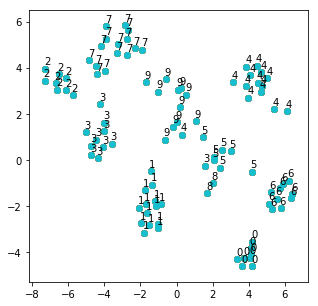

In [64]:
#plot_with_labels(target_matrix,labels)
#plot_with_labels(source_matrix, labels)
plot_with_labels(source_matrix_new, labels)

## Align The Centroids vs. the whole dataset

In [70]:
df1_group = df1.groupby(df1['labels'])

In [90]:
type(df1_group.get_group(1))

pandas.core.frame.DataFrame

In [96]:
def find_centroid(df): 
    x = np.mean(df.iloc[:, 0])
    y = np.mean(df.iloc[:, 1])
    return [x,y]

In [97]:
find_centroid(df1_group.get_group(1))

[-0.8656185, 4.125817]

In [146]:
def find_all_centroids(all_weights):
    etot_centroids = []
    for i in range(len(all_weights)):
        dfi = pd.DataFrame(all_weights[i])
        dfi['labels'] = labels
        ei_centroids = []
        for name, group in dfi.groupby(dfi['labels']):
            cent = find_centroid(group)
            ei_centroids.append(cent)
        ei_centroids = np.array(ei_centroids)
        etot_centroids.append(ei_centroids)
        #print(e1_centroids)
    return np.array(etot_centroids)

In [147]:
y = find_all_centroids(weights)

In [151]:
source_matrix = y[1]
target_matrix = y[0]
trans = make_transform(source_matrix, target_matrix)

source_matrix_new = apply_transform(source_matrix, trans)

In [152]:
source_matrix_new

array([[ 4.4114423 , -3.6844835 ],
       [-1.2043024 , -2.2502718 ],
       [-6.902654  ,  2.5574813 ],
       [-3.8628511 ,  0.39162537],
       [ 3.8119714 ,  3.5707412 ],
       [ 2.4953952 ,  0.4588765 ],
       [ 5.9144444 , -0.8568028 ],
       [-3.970137  ,  4.393532  ],
       [ 1.9969057 , -0.985729  ],
       [-0.46491846,  2.3946028 ]], dtype=float32)

In [154]:
trans.shape

(2, 2)